# Comparison of different RAG system settings and their performance
Purpose of the notebook: evaluate the performance of different RAG settings to find the configuration that works best for this usecase

Evaluate:
- Baseline Approach: with different embedding models and generative LLMs
- PDF Extraction: compare PyMuPDF and PyMuPDF4LLM
- Retrieval settings: chunk size, chunk overlap and Top K

# Preparation

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
import urllib3
import tenacity
import configparser
import markdown
import json
import pymupdf
import requests
import os
import io
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_experimental.text_splitter import SemanticChunker
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import CrossEncoderReranker
from langchain_community.cross_encoders import HuggingFaceCrossEncoder
from langchain_core.output_parsers import PydanticOutputParser
from langchain.schema import (
    AIMessage,
    HumanMessage,
    SystemMessage
)
from langchain.prompts import PromptTemplate
from langchain_core.prompts import ChatPromptTemplate
import tiktoken
import asyncio
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_huggingface import HuggingFacePipeline
from torch import cuda, bfloat16
from transformers import AutoTokenizer, BitsAndBytesConfig, AutoModelForCausalLM, pipeline
import torch
from torch import cuda, bfloat16
import transformers
from tqdm import tqdm
from math import ceil
from datasets import Dataset
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
import pymupdf4llm


from dotenv import load_dotenv
dotenv_path = os.path.expanduser("~/thesis/esg_extraction/.env")
load_dotenv(dotenv_path=dotenv_path)
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

# for working with huggingface
from huggingface_hub import login
HF_TOKEN = os.getenv("HUGGINGFACE_TOKEN")
login(HF_TOKEN)

## Validation approach
Use sample reports to manually hand code the "ground truth" that the output of the LLM is compared against
Source: Sustainability Reporting Navigator (crowd-source list of CSRD-compliant reports for fiscal years starting on 01/01/2024)

Downloaded CSV with information on all reports on the 08/04/2025 https://www.sustainabilityreportingnavigator.com/#/csrdreports 

In [9]:
reports_24 = pd.read_csv('esg_reports_2024.csv')
sample = reports_24[reports_24['company_withAccessInfo'].isin(['Continental AG', 'Schneider Electric*'])]
sample.head()

,Unnamed: 0,company_withAccessInfo,link,country,sector,industry,publication date,pages PDF,auditor
58,266,Schneider Electric*,https://www.se.com/ww/en/assets/564/document/5...,France,Resource Transformation,Electrical & Electronic Equipment,2025-03-26,186,PwC & Mazars
220,19,Continental AG,https://annualreport.continental.com/2024/en/s...,Germany,Transportation,Auto Parts,2025-03-18,125,PwC


In [10]:
# Read in the manually hand coded validation set (based on the sample reports)
validation_set = pd.read_excel('validation_dataset.xlsx')
validation_set.head()

,report_name,query,verdict,analysis,sources
0,ContinentalAG_2024,S1_A1,YES,"[[YES]] \n""The consolidation at group level of...","[175, 176]"
1,ContinentalAG_2024,S1_A2,YES,[[YES]] \nreport explicitly mentions character...,"[175, 176]"
2,ContinentalAG_2024,S1_A3,NO,[[NO]] \ndoes not describe the types of non-em...,[176]
3,ContinentalAG_2024,S1_A4,YES,"[[YES]]\nworking time arrangements, paying ade...","[110, 173, 174]"
4,ContinentalAG_2024,S1_A5,NO,[[NO]]\ndoes not explicitly describe the types...,"[173, 174]"


In [11]:
import pandas as pd

# Load your validation set
validation_set = pd.read_excel("validation_dataset.xlsx")

# ---- Helper: extract topic ----
validation_set["topic"] = validation_set["query"].str.extract(r"(S1_[A-Z])")

# 1️⃣ Overall YES/NO ratio
overall_ratio = (
    validation_set["verdict"]
    .value_counts()
    .to_frame(name="Count")
    .assign(Percentage=lambda x: (100 * x["Count"] / x["Count"].sum()).round(0).astype(int))
)

print("\n--- Overall YES/NO Ratio ---")
print(overall_ratio.to_string())

# 2️⃣ YES/NO ratio per report
per_report_ratio = (
    validation_set.groupby(["report_name", "verdict"])
    .size()
    .unstack(fill_value=0)
)
per_report_ratio["Total"] = per_report_ratio.sum(axis=1)
per_report_ratio["YES_%"] = ((per_report_ratio["YES"] / per_report_ratio["Total"]) * 100).round(0).astype(int)
per_report_ratio["NO_%"] = ((per_report_ratio["NO"] / per_report_ratio["Total"]) * 100).round(0).astype(int)

print("\n--- YES/NO Ratio per Report ---")
print(per_report_ratio.to_string())

# 3️⃣ YES/NO ratio per topic
per_topic_ratio = (
    validation_set.groupby(["topic", "verdict"])
    .size()
    .unstack(fill_value=0)
)
per_topic_ratio["Total"] = per_topic_ratio.sum(axis=1)
per_topic_ratio["YES_%"] = ((per_topic_ratio["YES"] / per_topic_ratio["Total"]) * 100).round(0).astype(int)
per_topic_ratio["NO_%"] = ((per_topic_ratio["NO"] / per_topic_ratio["Total"]) * 100).round(0).astype(int)

print("\n--- YES/NO Ratio per Topic ---")
print(per_topic_ratio.to_string())

# 4️⃣ YES/NO ratio per topic per report
per_topic_report_ratio = (
    validation_set.groupby(["report_name", "topic", "verdict"])
    .size()
    .unstack(fill_value=0)
)
per_topic_report_ratio["Total"] = per_topic_report_ratio.sum(axis=1)
per_topic_report_ratio["YES_%"] = ((per_topic_report_ratio["YES"] / per_topic_report_ratio["Total"]) * 100).round(0).astype(int)
per_topic_report_ratio["NO_%"] = ((per_topic_report_ratio["NO"] / per_topic_report_ratio["Total"]) * 100).round(0).astype(int)

print("\n--- YES/NO Ratio per Topic per Report ---")
print(per_topic_report_ratio.to_string())



--- Overall YES/NO Ratio ---
         Count  Percentage
verdict                   
YES         85          65
NO          45          35

--- YES/NO Ratio per Report ---
verdict                 NO  YES  Total  YES_%  NO_%
report_name                                        
ContinentalAG_2024      25   40     65     62    38
SchneiderElectric_2024  20   45     65     69    31

--- YES/NO Ratio per Topic ---
verdict  NO  YES  Total  YES_%  NO_%
topic                               
S1_A     10   22     32     69    31
S1_B      2    6      8     75    25
S1_C      8   14     22     64    36
S1_D      6   18     24     75    25
S1_E      1    9     10     90    10
S1_F      7   15     22     68    32
S1_G     11    1     12      8    92

--- YES/NO Ratio per Topic per Report ---
verdict                       NO  YES  Total  YES_%  NO_%
report_name            topic                             
ContinentalAG_2024     S1_A    7    9     16     56    44
                       S1_B    0    4  

/tmp/ipykernel_4090659/1395462411.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


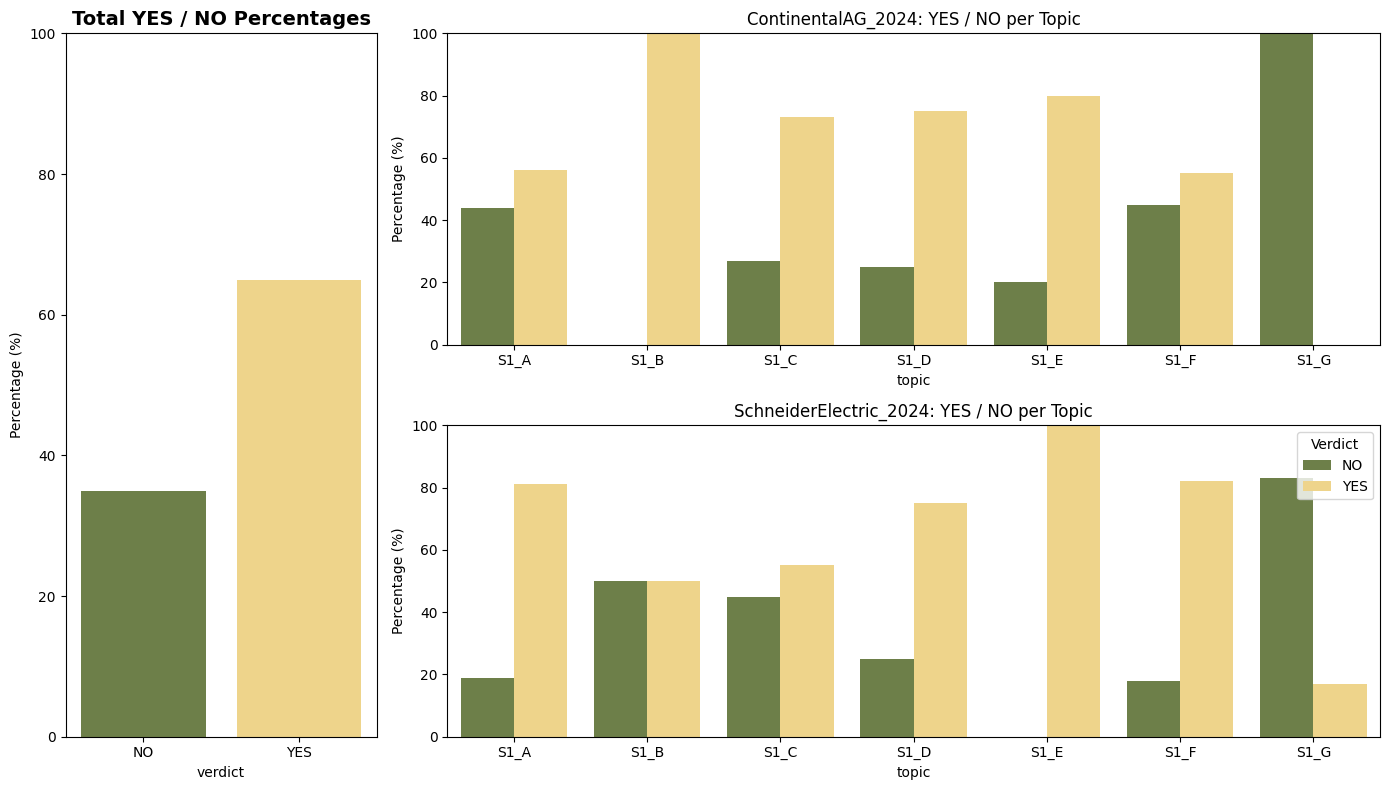

In [12]:
# Extract topic from query
validation_set["topic"] = validation_set["query"].str.extract(r"(S1_[A-Z])")

# Compute counts
df_counts = (
    validation_set.groupby(["report_name", "topic", "verdict"])
    .size()
    .reset_index(name="count")
)

# Total counts for percentages
df_counts["total"] = df_counts.groupby(["report_name", "topic"])["count"].transform("sum")
df_counts["percentage"] = (df_counts["count"] / df_counts["total"] * 100).round(0).astype(int)

custom_palette = ["#708840", "#FEDC7B"]

# ---- 1. Data for total plot ----
df_total = (
    validation_set.groupby(["verdict"])
    .size()
    .reset_index(name="count")
)
df_total["percentage"] = (df_total["count"] / df_total["count"].sum() * 100).round(0).astype(int)

# ---- 2. Create figure with GridSpec ----
fig = plt.figure(figsize=(14, 8))
gs = fig.add_gridspec(2, 2, width_ratios=[1, 3])  # Left is wider

# Big total plot on left spanning two rows
ax_total = fig.add_subplot(gs[:, 0])
sns.barplot(
    data=df_total,
    x="verdict",
    y="percentage",
    palette=custom_palette,
    ax=ax_total
)
ax_total.set_title("Total YES / NO Percentages", fontsize=14, weight="bold")
ax_total.set_ylabel("Percentage (%)")
ax_total.set_ylim(0, 100)

# ---- 3. Report-specific plots on right ----
report_names = df_counts["report_name"].unique()

# First report (top-right)
ax_r1 = fig.add_subplot(gs[0, 1])
sns.barplot(
    data=df_counts[df_counts["report_name"] == report_names[0]],
    x="topic",
    y="percentage",
    hue="verdict",
    palette=custom_palette,
    ax=ax_r1
)
ax_r1.set_title(f"{report_names[0]}: YES / NO per Topic", fontsize=12)
ax_r1.set_ylabel("Percentage (%)")
ax_r1.set_ylim(0, 100)
ax_r1.legend().remove()

# Second report (bottom-right)
ax_r2 = fig.add_subplot(gs[1, 1])
sns.barplot(
    data=df_counts[df_counts["report_name"] == report_names[1]],
    x="topic",
    y="percentage",
    hue="verdict",
    palette=custom_palette,
    ax=ax_r2
)
ax_r2.set_title(f"{report_names[1]}: YES / NO per Topic", fontsize=12)
ax_r2.set_ylabel("Percentage (%)")
ax_r2.set_ylim(0, 100)
ax_r2.legend(title="Verdict", loc="upper right")

# ---- 4. Layout adjustments ----
plt.tight_layout()
plt.show()


In [13]:
# function to calculate the performance of the YES/NO predictions
def evaluate_verdicts(df_val, predicted_results, verbose=False):
    print("\n--- LLM Evaluation: Evaluating performance on verdicts ---")
    y_true, y_pred = [], []
    mismatches = []
    dropped = 0
    total = len(df_val)

    for _, row in df_val.iterrows():
        report = row["report_name"]
        query = row["query"]
        true_verdict = row["verdict"]
        pred_verdict = predicted_results.get(report, {}).get(query, {}).get("verdict")
        true_analysis = row["analysis"]
        pred_analysis = predicted_results.get(report, {}).get(query, {}).get("analysis")

        # Drop if either is missing or N/A
        if pred_verdict is None or pred_verdict == "N/A":
            if verbose:
                print(f"[DROPPED] {report} | {query} | True verdict: {true_verdict} | Predicted verdict: {pred_verdict}, LLM Analysis: {analysis}")
            dropped += 1
            continue

        y_true.append(true_verdict)
        y_pred.append(pred_verdict)

        if verbose and true_verdict != pred_verdict:
            mismatches.append((report, query, true_verdict, pred_verdict, true_analysis, pred_analysis))

    if verbose and mismatches:
        print("\n Mismatches:")
        for report, query, true, pred, true_analysis, pred_analysis in mismatches:
            print(f"  {report} | {query} ")
            print(f" TRUE VERDICT: {true}, TRUE ANALYSIS   : {true_analysis}")
            print(f" PRED VERDICT: {pred}, PRED ANALYSIS   : {pred_analysis}")

    print(f"\n Dropped {dropped} of {total} queries due to missing verdicts.")

    # Check to avoid errors when nothing is left
    if not y_true:
        print(" No valid data to evaluate.")
        return {
            "accuracy": None,
            "precision": None,
            "recall": None,
            "f1_score": None
        }

    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted', zero_division=0
    )

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }

In [14]:
summary_results = []

def evaluate_verdicts(df_val, predicted_results, config_name, llm_name, embedding_model, resources, verbose=False):
    print("\n--- LLM Evaluation: Evaluating performance on verdicts ---")
    y_true, y_pred = [], []
    mismatches = []
    dropped = 0
    total = len(df_val)

    for _, row in df_val.iterrows():
        report = row["report_name"]
        query = row["query"]
        true_verdict = row["verdict"]
        pred_verdict = predicted_results.get(report, {}).get(query, {}).get("verdict")
        true_analysis = row["analysis"]
        pred_analysis = predicted_results.get(report, {}).get(query, {}).get("analysis")

        if pred_verdict is None or pred_verdict == "N/A":
            dropped += 1
            continue

        y_true.append(true_verdict)
        y_pred.append(pred_verdict)

        if verbose and true_verdict != pred_verdict:
            mismatches.append((report, query, true_verdict, pred_verdict, true_analysis, pred_analysis))

    print(f"\n Dropped {dropped} of {total} queries due to missing verdicts.")

    if not y_true:
        print(" No valid data to evaluate.")
        metrics = {"accuracy": None, "precision": None, "recall": None, "f1_score": None}
    else:
        acc = accuracy_score(y_true, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average='weighted', zero_division=0
        )
        metrics = {
            "accuracy": round(acc, 3),
            "precision": round(precision, 3),
            "recall": round(recall, 3),
            "f1_score": round(f1, 3)
        }

    # Append to global summary
    summary_results.append({
        "Config": config_name,
        "LLM": llm_name,
        "Embedding Model": embedding_model,
        "Accuracy": metrics["accuracy"],
        "Recall": metrics["recall"],
        "Precision": metrics["precision"],
        "F1-Score": metrics["f1_score"],
        "Resources": resources
    })

    return metrics

## Code needed for RAG

In [15]:
### HELPER FUNCTIONS ###

# preparing filenames
def prepare_filename(name):
    return re.sub(r'[\\/*?:"<>|]', "", name)
    

def _docs_to_string(docs, with_source=True):
    output = ""
    for doc in docs:
        output += "Content: {}\n".format(doc.page_content)
        if with_source:
            output += "Source: {}\n".format(doc.metadata['page'])
        output += "\n---\n"
    return output


def _find_answer(full_text):
    try:
        for line in full_text.splitlines():
            if "ANSWER" in line:
                idx = line.find(":") + 1
                return line[idx:].strip().strip('",')
        return full_text.strip()  # fallback if no ANSWER found
    except Exception:
        return full_text.strip()


def _find_verdict(answer_text):
    if not answer_text:
        return "N/A"
    
    # Look for [[YES]] or [[NO]], case-insensitive
    match = re.search(r'\[\[\s*(YES|NO)\s*\]\]', answer_text, re.IGNORECASE)
    if match:
        return match.group(1).upper()
    
    return "N/A"


def _find_sources(full_text):
    # Attempt to match a SOURCES line first
    sources_match = re.search(r"SOURCES\s*:\s*\[([^\]]+)\]", full_text)
    if sources_match:
        number_list = re.findall(r'\d+', sources_match.group(1))
        return [int(n) for n in number_list]

    # Fallback: extract all numbers from full text
    return [int(n) for n in re.findall(r'\b\d{3,5}\b', full_text)]  # assumes sources have 3-5 digits


In [16]:
# based on the example of Colesanti Senni et al., 2025 defined queries and guidline pairs to capture ESRS guidlines
esrs_metadata = pd.read_excel('../EsrsMetadata.xlsx')
print(esrs_metadata[:3])

# Create QUERIES dictionary
QUERIES = dict(zip(esrs_metadata["query_id"], esrs_metadata["query"]))
print(QUERIES)

# Create GUIDELINES dictionary
GUIDELINES = dict(zip(esrs_metadata["query_id"], esrs_metadata["guidelines"]))
print(GUIDELINES)

  topic_id query_id                                              query  \
0     S1_A    S1_A1  Does the company disclose whether all people i...   
1     S1_A    S1_A2  Does the company describe the types of employe...   
2     S1_A    S1_A3  Does the company describe the types of non-emp...   

                                          guidelines      esrs paragraph  \
0  Focus on whether the company explicitly confir...  S1.SBM-3        14   
1  Check whether the company identifies which typ...  S1.SBM-3      14 a   
2  Assess whether the company identifies non-empl...  S1.SBM-3      14 a   

   related_ar  
0  AR 6 - AR7  
1         NaN  
2         NaN  
{'S1_A1': 'Does the company disclose whether all people in its own workforce who could be materially impacted are included in the scope of its disclosure?', 'S1_A2': 'Does the company describe the types of employees in its own workforce that are subject to material impacts?', 'S1_A3': 'Does the company describe the types of non-empl

In [17]:
## 1. Parse the Document ##
def parse_pdf(path=None, url=None):
    assert (path is not None) != (url is not None), "Provide either a local path or a URL."
    
    if path:
        pdf = pymupdf.open(path)
    else:
        response = requests.get(url)
        pdf = pymupdf.open(stream=io.BytesIO(response.content), filetype='pdf')
    
    pages = [page.get_text() for page in pdf]
    full_text = ''.join(pages)
    
    return pages, full_text


## 2. Chunk the text ##
def chunk_text(pages, chunk_size, chunk_overlap):
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=len,
        separators=["\n\n", "\n", " "],
    )

    chunks = []
    metadata = []

    for idx, page in enumerate(pages):
        page_chunks = splitter.split_text(page)
        chunks.extend(page_chunks)
        metadata.extend([{"page": str(idx + 1)}] * len(page_chunks))

    return chunks, metadata


## 3. Generate and store vector representations ##
def get_vectorstore(chunks, metadata, db_path, embedding_model):

    # if vector representation database already exists load FAISS
    if os.path.exists(db_path):
        vectorstore = FAISS.load_local(db_path, embeddings=embedding_model, allow_dangerous_deserialization=True)
    else:
        vectorstore = FAISS.from_texts(chunks, embedding_model, metadatas=metadata)
        vectorstore.save_local(db_path)

    return vectorstore


## 4. Retrieve relevant chunks ##
def retrieve_chunks(vectorstore, queries, report_id, top_k):
    retriever = vectorstore.as_retriever(search_kwargs={"k": top_k})
    
    section_text_dict = {}

    for key, query in queries.items():
        section_text_dict[key] = retriever.invoke(query)
    
    return {report_id: section_text_dict}


# Baseline Approach

In [18]:
TOP_K = 8
CHUNK_SIZE = 350
CHUNK_OVERLAP = 50
ANSWER_LENGTH=200
MAX_TOKEN=500

## 1. OpenAI

In [10]:
PROMPT_TEMPLATE = ("""
You are a senior sustainabiliy analyst with expertise in the european reporting standards evaluating a company's disclosure on social sustainability.


You are presented with the following sources from the company's annual report:
--------------------- [BEGIN OF SOURCES]\n
{sources}\n
--------------------- [END OF SOURCES]\n

Given the sources information and no prior knowledge, your main task is to respond to the posed question encapsulated in "||".
Question: ||{query}||

Please consider the following additional explanation to the question encapsulated in "+++++" as crucial for answering the question:
+++++ [BEGIN OF EXPLANATION]
{guideline}
+++++ [END OF EXPLANATION]

Please enforce to the following guidelines in your answer:
1. Your response must be precise, thorough, and grounded on specific extracts from the report to verify its authenticity.
2. If you are unsure, simply acknowledge the lack of knowledge, rather than fabricating an answer.
3. Keep your ANSWER within {answer_length} words.
4. Be skeptical to the information disclosed in the report as there might be greenwashing (exaggerating the firm's environmental responsibility). Always answer in a critical tone.
5. Cheap talks are statements that are costless to make and may not necessarily reflect the true intentions or future actions of the company. Be critical for all cheap talks you discovered in the report.
6. Always acknowledge that the information provided is representing the company's view based on its report.
7. Scrutinize whether the report is grounded in quantifiable, concrete data or vague, unverifiable statements, and communicate your findings.
8. Start your answer with a "[[YES]]"" or ""[[NO]]"" depending on whether you would answer the question with a yes or no. Always complement your judgement on yes or no with a short explanation that summarizes the sources in an informative way, i.e. provide details.

Format your answer in JSON format with the two keys: ANSWER (this should contain your answer string without sources), and SOURCES (this should be a list of the SOURCE numbers that were referenced in your answer).
Your FINAL_ANSWER in JSON (ensure there's no format error):
""")

disclosure_prompt = PromptTemplate(
    template=PROMPT_TEMPLATE,
    input_variables=["query", "sources", "guideline", "answer_length"]
)

SYSTEM_PROMPT = "You are an AI assistant in the role of a Senior Equity Analyst with expertise in sustainability reporting that analyzes companys' annual reports."

In [11]:
llm_name = "gpt-4.1-mini-2025-04-14"
openai_embedding_model = OpenAIEmbeddings() # initialize embedding model
openai_llm = ChatOpenAI(model=llm_name, temperature=0, max_tokens=MAX_TOKEN) # initialize LLM

## 5. Generate Augmented LLM answer ##
def generate_llm_answer(report_list, section_text_dict, llm, answer_length=ANSWER_LENGTH):
    final_results_by_report = {}

    for report in report_list:
        print(f"--- Generating Answers for Report: {report} ---")
        report_assessments = {}
        
        for key, query_text in QUERIES.items():
            context_str = _docs_to_string(section_text_dict[report].get(key, []), with_source=True)
            
            # Skip if no context is found
            if not context_str.strip():
                print(f"    -> Skipping key '{key}' due to empty context.")
                report_assessments[key] = {
                    "verdict": "N/A",
                    "analysis": "N/A",
                    "sources": []
                }
                continue

            # 1. Format the prompt for the current question
            current_prompt_text = disclosure_prompt.format(
                query=query_text,
                sources=context_str,
                guideline=GUIDELINES.get(key, ""),
                answer_length=answer_length
            )
            
            current_message = [
                SystemMessage(content=SYSTEM_PROMPT),
                HumanMessage(content=current_prompt_text)
            ]

            # 2. Make a single, synchronous API call
            response = llm.invoke(current_message)
            text = response.content
                
            # 3. Parse the output            
            try:
                parsed_json = json.loads(text)
                answer = parsed_json.get("ANSWER", "")
                sources = parsed_json.get("SOURCES", [])

            except (json.JSONDecodeError, TypeError) as e:
                print(f"[Warning] JSON parsing failed for key '{key}' in report '{report}': {e}")
                answer = _find_answer(text)
                sources = _find_sources(text)
                
            verdict = _find_verdict(answer)
            report_assessments[key] = {
                "verdict": verdict,
                "analysis": answer,
                "sources": sources
            }

        final_results_by_report[report] = report_assessments
        
    return final_results_by_report

In [12]:
start_time = time.time()

# Your pipeline execution 
retrieved_chunks = {}  # Holds retrieved text chunks per report
report_ids = []        # Stores report IDs for final LLM analysis

# Loop through each report in your sample DataFrame
for idx, row in sample.iterrows():
    company_name = row['company_withAccessInfo']
    report_id = f"{prepare_filename(company_name)}_2024".replace(" ", "")
    print(f"\n Processing: {report_id}")

    # 1. Parse the document
    path = f"./sample_reports/{report_id}.pdf"
    pages, _ = parse_pdf(path=path)

    # 2. Chunk the text
    chunks, metadata = chunk_text(pages, chunk_size=CHUNK_SIZE, chunk_overlap=CHUNK_OVERLAP)

    # 3. Generate and store vector representations
    db_path = f"./faiss_db_Baseline1/{report_id}"
    vectorstore = get_vectorstore(chunks, metadata, db_path, embedding_model=openai_embedding_model)

    # 4. Retrieve the relevant chunks
    result = retrieve_chunks(vectorstore, queries=QUERIES, report_id=report_id, top_k=TOP_K)
    retrieved_chunks.update(result)
    report_ids.append(report_id)

# 5. Generate LLM answers
final_analysis = generate_llm_answer(report_ids, retrieved_chunks, openai_llm)


time_per_report = (time.time() - start_time) / len(report_ids) / 60  # in minutes
print("Processing time per report in minutes", time_per_report)

evaluate_verdicts(
    validation_set,
    final_analysis,
    config_name="Baseline 1",
    llm_name="OpenAI: gpt-4.1-mini-2025-04-14",
    embedding_model="OpenAI: text-embedding-ada-002",
    resources=f"{time_per_report:.2f} min/report"
)



 Processing: SchneiderElectric_2024

 Processing: ContinentalAG_2024
--- Generating Answers for Report: SchneiderElectric_2024 ---
--- Generating Answers for Report: ContinentalAG_2024 ---
Processing time per report in minutes 6.963438194990158

--- LLM Evaluation: Evaluating performance on verdicts ---

 Dropped 0 of 130 queries due to missing verdicts.


{'accuracy': 0.808, 'precision': 0.811, 'recall': 0.808, 'f1_score': 0.796}

In [13]:
df_summary = pd.DataFrame(summary_results)
print(df_summary)
df_summary.to_excel("rag_comparison.xlsx", index=False)

       Config                        LLM                 Embedding Model  \
0  Baseline 1  OpenAI: gpt-4o-2024-08-06  OpenAI: text-embedding-ada-002   

   Accuracy  Recall  Precision  F1-Score        Resources  
0     0.808   0.808      0.811     0.796  6.96 min/report  


## 2. Llama 3.1 8B and Qwen 0.6B
Llama 3.1 8B
- context length: 128k https://huggingface.co/meta-llama/Llama-3.1-8B-Instruct
- adjustments needed: batching for efficient workflow, b/c computation on own ressources

- Llama performed badly in keeping the JSON format that was prompted --> change in the System Prompt

Qwen 0.6B
- Place 4 in MTEB Leaderboard (26.06.2025), best for 2 GB Memory Usage https://huggingface.co/spaces/mteb/leaderboard
- Number of Paramaters: 0.6B
- Context Length: 32k
- Embedding Dimension: Up to 1024, supports user-defined output dimensions ranging from 32 to 1024
https://huggingface.co/Qwen/Qwen3-Embedding-0.6B 

In [19]:
PROMPT_TEMPLATE = ("""
You are a senior sustainabiliy analyst with expertise in the european reporting standards evaluating a company's disclosure on social sustainability.


You are presented with the following sources from the company's annual report:
--------------------- [BEGIN OF SOURCES]\n
{sources}\n
--------------------- [END OF SOURCES]\n

Given the sources information and no prior knowledge, your main task is to respond to the posed question encapsulated in "||".
Question: ||{query}||

Please consider the following additional explanation to the question encapsulated in "+++++" as crucial for answering the question:
+++++ [BEGIN OF EXPLANATION]
{guideline}
+++++ [END OF EXPLANATION]

### Response Instructions ###
Please enforce to the following guidelines in your ANSWER:
1. Your response must be precise, thorough, and grounded on specific extracts from the report to verify its authenticity.
2. If you are unsure, simply acknowledge the lack of knowledge, rather than fabricating an answer.
3. Be skeptical to the information disclosed in the report as there might be greenwashing (exaggerating the firm's environmental responsibility). Always answer in a critical tone.
4. Cheap talks are statements that are costless to make and may not necessarily reflect the true intentions or future actions of the company. Be critical for all cheap talks you discovered in the report.
5. Always acknowledge that the information provided is representing the company's view based on its report.
6. Scrutinize whether the report is grounded in quantifiable, concrete data or vague, unverifiable statements, and communicate your findings.
7. Start your ANSWER with a "[[YES]]"" or ""[[NO]]"" depending on whether you would answer the question with a yes or no. Always complement your judgement on yes or no with a short explanation that summarizes the sources in an informative way, i.e. provide details.
8. Keep your ANSWER within {answer_length} words.

### Formatting Instructions ###
- Format your answer in JSON format with the two keys: ANSWER (this should contain your answer string without sources), and SOURCES (this should be a list of the SOURCE numbers that were referenced in your answer).
- Your response **must** be returned as a **valid JSON object**.
- Only output the JSON object — no preamble, no markdown, no extra commentary.
- Use this exact format for your final output:
{{
  "ANSWER": "[[YES]] or [[NO]] Here follows your explanation",
  "SOURCES": ["1", "216", "181-182", "174"]
}}

Your FINAL_ANSWER in JSON (ensure there's no format error):
""")

disclosure_prompt = PromptTemplate(
    template=PROMPT_TEMPLATE,
    input_variables=["query", "sources", "guideline", "answer_length"]
)

SYSTEM_PROMPT = "You are an AI assistant in the role of a Senior Equity Analyst with expertise in sustainability reporting that analyzes companys' annual reports."

In [20]:
BATCH_SIZE=64
TEMPERATURE=0.01

### loading the model
llm_name = "meta-llama/Llama-3.1-8B-Instruct"

device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'

tokenizer = AutoTokenizer.from_pretrained(llm_name)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = "left" # important for batching since Llama is a decoder-only architecture

# to reduce memory usage and speed up performance
quantization_config = BitsAndBytesConfig(load_in_4bit=True, # maximizing speed and minimizing memory
                                         bnb_4bit_compute_dtype=torch.bfloat16, # computations in bfloat16
                                         bnb_4bit_use_double_quant=True,
                                         bnb_4bit_quant_type= "nf4"
                                         )

model = AutoModelForCausalLM.from_pretrained(
    llm_name,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    quantization_config=quantization_config
)

# enable evaluation mode to allow model inference
model.eval()

print(f"Model loaded on {device}")

generate_text = transformers.pipeline(
    model=model,
    tokenizer=tokenizer,
    task='text-generation',
    return_full_text=True,   # Important for parsing logic
    temperature=TEMPERATURE,        
    max_new_tokens=MAX_TOKEN, 
    batch_size=BATCH_SIZE
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Device set to use cuda:0


Model loaded on cuda:0


In [21]:
BATCH_SIZE=64

generate_text = transformers.pipeline(
    model=model,
    tokenizer=tokenizer,
    task='text-generation',
    return_full_text=True,   # Important for parsing logic
    temperature=TEMPERATURE,        
    max_new_tokens=MAX_TOKEN, 
    batch_size=BATCH_SIZE
)

Device set to use cuda:0


In [22]:
# Initialize the new embedding model
embeddings_qwen = HuggingFaceEmbeddings(
    model_name="Qwen/Qwen3-Embedding-0.6B",
    model_kwargs={'device': 'cuda'} # specify device='cpu' if GPU not available 
)

In [23]:
### 5. Inference with Llama ###

    ## A) Prepare Prompts and Metadata ##
def prepare_prompts(report_list, section_text_dict):
    print("--- Step 1: Preparing all prompts ---")
    prompts_to_process = []
    metadata_for_prompts = []
    # Initialize a dict to hold results, including skipped items
    final_results = {report: {} for report in report_list}

    for report in report_list:
        for key, query_text in QUERIES.items():
            context_str = _docs_to_string(section_text_dict[report].get(key, []))

            if not context_str.strip():
                print(f"  -> Skipping '{report}/{key}' due to empty context.")
                final_results[report][key] = {
                    "verdict": "NO",
                    "analysis": "No relevant context was found to answer the question.",
                    "sources": []
                }
                continue

            prompt_text = disclosure_prompt.format(
                query=query_text,
                sources=context_str,
                guideline=GUIDELINES.get(key, ""),
                answer_length=ANSWER_LENGTH
            )
            
            prompts_to_process.append([
                {"role": "system", "content": SYSTEM_PROMPT},
                {"role": "user", "content": prompt_text}
            ])
            metadata_for_prompts.append({"report": report, "key": key})
            
    return prompts_to_process, metadata_for_prompts, final_results


    ## B) Run batched Inference ##
def run_batched_inference(prompts, generate_text_pipeline, batch_size=BATCH_SIZE):
    print(f"\n--- Step 2: Sending {len(prompts)} prompts to the pipeline ---")
    if not prompts:
        print("No prompts to process.")
        return []
    
    # The pipeline automatically handles tokenization and batching
    start_time = time.time()
    responses = generate_text_pipeline(prompts, batch_size=batch_size)
    # empty GPU memory
    torch.cuda.empty_cache()
    print(f"Generated LLM answers — Computation time: {(time.time() - start_time) / 60:.2f} minutes")
    return responses


    ## C) Parse the results ##
def parse_results(responses, metadata, existing_results):
    print("\n--- Step 3: Parsing all responses ---")
    for meta, response in zip(metadata, responses):
        report = meta["report"]
        key = meta["key"]
        
        full_text = response[0]['generated_text'][-1]['content']
        
        json_match = re.search(r'\{.*?\}', full_text, re.DOTALL)
        
        if json_match:
            json_str = json_match.group(0)
            try:
                parsed_json = json.loads(json_str)
                answer = parsed_json.get("ANSWER", "")
                sources = parsed_json.get("SOURCES", [])
            except json.JSONDecodeError as e:
                print(f"\n--- JSON decode error with {report} {key} ---\n{e}\nProblematic JSON:\n{json_str}\nFull text:\n{full_text}\n")
                answer = _find_answer(full_text)
                sources = _find_sources(full_text)
        else:
            print("No JSON found. This was the LLM response:", full_text)
            answer = _find_answer(full_text)
            sources = _find_sources(full_text)

        verdict = _find_verdict(answer)
        if verdict in [None, "N/A"]:
            answer = "N/A"
            sources = "N/A"
            print(f"\n--- Verdict not found in {report} {key} ---\nFull LLM response:\n{full_text}\n")
        
        existing_results[report][key] = {
            "verdict": verdict,
            "analysis": answer,
            "sources": sources
        }
        
    return existing_results

In [23]:
start_time = time.time()

# Your pipeline execution 
retrieved_chunks = {}  # Holds retrieved text chunks per report
report_ids = []        # Stores report IDs for final LLM analysis

# Loop through each report in your sample DataFrame
for idx, row in sample.iterrows():
    company_name = row['company_withAccessInfo']
    report_id = f"{prepare_filename(company_name)}_2024".replace(" ", "")
    print(f"\n Processing: {report_id}")

    # 1. Parse the document
    path = f"./sample_reports/{report_id}.pdf"
    pages, _ = parse_pdf(path=path)

    # 2. Chunk the text
    chunks, metadata = chunk_text(pages, chunk_size=CHUNK_SIZE, chunk_overlap=CHUNK_OVERLAP)

    # 3. Generate and store vector representations
    db_path = f"./faiss_db_Baseline2/{report_id}"
    vectorstore = get_vectorstore(chunks, metadata, db_path, embedding_model=embeddings_qwen)

    # 4. Retrieve the relevant chunks
    result = retrieve_chunks(vectorstore, queries=QUERIES, report_id=report_id, top_k=TOP_K)
    retrieved_chunks.update(result)
    report_ids.append(report_id)

# 5. Generate LLM answers
    # 1. Prepare prompts
prompts, metadata, final_analysis = prepare_prompts(
    report_list=report_ids,
    section_text_dict=retrieved_chunks
)
    # 2. Run inference
model_responses = run_batched_inference(prompts, generate_text)
    # 3. Parse and finalize results
final_analysis = parse_results(
    model_responses,
    metadata,
    final_analysis
)

time_per_report = (time.time() - start_time) / len(report_ids) / 60  # in minutes
print("Processing time per report in minutes", time_per_report)

evaluate_verdicts(
    validation_set,
    final_analysis,
    config_name="Baseline 2",
    llm_name="Llama 3.1 8B - Instruct",
    embedding_model="Qwen 0.6B",
    resources=f"{time_per_report:.2f} min/report"
)


 Processing: SchneiderElectric_2024

 Processing: ContinentalAG_2024
--- Step 1: Preparing all prompts ---

--- Step 2: Sending 130 prompts to the pipeline ---
Generated LLM answers — Computation time: 3.58 minutes

--- Step 3: Parsing all responses ---
Processing time per report in minutes 1.8485245803991954

--- LLM Evaluation: Evaluating performance on verdicts ---

 Dropped 0 of 130 queries due to missing verdicts.


{'accuracy': 0.769, 'precision': 0.788, 'recall': 0.769, 'f1_score': 0.774}

In [24]:
df_summary = pd.DataFrame(summary_results)
print(df_summary)
df_summary.to_excel("rag_comparison.xlsx", index=False)

       Config                        LLM                 Embedding Model  \
0  Baseline 1  OpenAI: gpt-4o-2024-08-06  OpenAI: text-embedding-ada-002   
1  Baseline 2    Llama 3.1 8B - Instruct                       Qwen 0.6B   

   Accuracy  Recall  Precision  F1-Score        Resources  
0     0.808   0.808      0.811     0.796  6.96 min/report  
1     0.769   0.769      0.788     0.774  1.85 min/report  


## 3. Llama 3.1 8B and Qwen 4B
- Place 3 in MTEB Leaderboard (16.07.2025), 2nd best open source https://huggingface.co/spaces/mteb/leaderboard
- Number of Paramaters: 4B
- Context Length: 32k
- Embedding Dimension: Up to 2560, supports user-defined output dimensions ranging from 32 to 2560
  https://huggingface.co/Qwen/Qwen3-Embedding-4B

In [13]:
# Initialize the embedding model
embeddings_qwen_4B = HuggingFaceEmbeddings(
    model_name="Qwen/Qwen3-Embedding-4B",
    model_kwargs={'device': 'cuda'} # specify device='cpu' if GPU not available 
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [15]:
start_time = time.time()

# Your pipeline execution 
retrieved_chunks = {}  # Holds retrieved text chunks per report
report_ids = []        # Stores report IDs for final LLM analysis

# Loop through each report in your sample DataFrame
for idx, row in sample.iterrows():
    company_name = row['company_withAccessInfo']
    report_id = f"{prepare_filename(company_name)}_2024".replace(" ", "")
    print(f"\n Processing: {report_id}")

    # 1. Parse the document
    path = f"./sample_reports/{report_id}.pdf"
    pages, _ = parse_pdf(path=path)

    # 2. Chunk the text
    chunks, metadata = chunk_text(pages, chunk_size=CHUNK_SIZE, chunk_overlap=CHUNK_OVERLAP)

    # 3. Generate and store vector representations
    db_path = f"./faiss_db_Baseline3/{report_id}"
    vectorstore = get_vectorstore(chunks, metadata, db_path, embedding_model=embeddings_qwen_4B)

    # 4. Retrieve the relevant chunks
    result = retrieve_chunks(vectorstore, queries=QUERIES, report_id=report_id, top_k=TOP_K)
    retrieved_chunks.update(result)
    report_ids.append(report_id)

# 5. Generate LLM answers
    # 1. Prepare prompts
prompts, metadata, final_analysis = prepare_prompts(
    report_list=report_ids,
    section_text_dict=retrieved_chunks
)
    # 2. Run inference
model_responses = run_batched_inference(prompts, generate_text)
    # 3. Parse and finalize results
final_analysis = parse_results(
    model_responses,
    metadata,
    final_analysis
)

time_per_report = (time.time() - start_time) / len(report_ids) / 60  # in minutes
print("Processing time per report in minutes", time_per_report)

evaluate_verdicts(
    validation_set,
    final_analysis,
    config_name="Baseline 3",
    llm_name="Llama 3.1 8B - Instruct",
    embedding_model="Qwen 4B",
    resources=f"{time_per_report:.2f} min/report"
)


 Processing: SchneiderElectric_2024

 Processing: ContinentalAG_2024
--- Step 1: Preparing all prompts ---

--- Step 2: Sending 130 prompts to the pipeline ---
Generated LLM answers — Computation time: 3.12 minutes

--- Step 3: Parsing all responses ---
Processing time per report in minutes 9.324741073449452

--- LLM Evaluation: Evaluating performance on verdicts ---

 Dropped 0 of 130 queries due to missing verdicts.


{'accuracy': 0.7, 'precision': 0.733, 'recall': 0.7, 'f1_score': 0.708}

In [16]:
# read in old summary
old_comparison = pd.read_excel('rag_comparison.xlsx')

df_new = pd.DataFrame(summary_results)  # Your newly calculated metrics
df_summary = pd.concat([old_comparison, df_new], ignore_index=True)
print(df_summary)

# Save back to the same file
df_summary.to_excel("rag_comparison.xlsx", index=False)

       Config                        LLM                 Embedding Model  \
0  Baseline 1  OpenAI: gpt-4o-2024-08-06  OpenAI: text-embedding-ada-002   
1  Baseline 2    Llama 3.1 8B - Instruct                       Qwen 0.6B   
2  Baseline 3    Llama 3.1 8B - Instruct                         Qwen 4B   

   Accuracy  Recall  Precision  F1-Score        Resources  
0     0.808   0.808      0.811     0.796  6.96 min/report  
1     0.769   0.769      0.788     0.774  1.85 min/report  
2     0.700   0.700      0.733     0.708  9.32 min/report  


## 4. Llama 3.3 70B and Qwen 0.6B

In [ ]:
BATCH_SIZE=16
TEMPERATURE=0.01

### loading the model
llm_name = "meta-llama/Llama-3.3-70B-Instruct"

device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'

tokenizer = AutoTokenizer.from_pretrained(llm_name)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = "left" # important for batching since Llama is a decoder-only architecture

# to reduce memory usage and speed up performance
quantization_config = BitsAndBytesConfig(load_in_4bit=True, # maximizing speed and minimizing memory
                                         bnb_4bit_compute_dtype=torch.bfloat16, # computations in bfloat16
                                         bnb_4bit_use_double_quant=True,
                                         bnb_4bit_quant_type= "nf4"
                                         )

model = AutoModelForCausalLM.from_pretrained(
    llm_name,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    quantization_config=quantization_config
)

# enable evaluation mode to allow model inference
model.eval()

print(f"Model loaded on {device}")

generate_text = transformers.pipeline(
    model=model,
    tokenizer=tokenizer,
    task='text-generation',
    return_full_text=True,   # Important for parsing logic
    temperature=TEMPERATURE,        
    max_new_tokens=MAX_TOKEN, 
    batch_size=BATCH_SIZE
)

# Initialize the new embedding model
embeddings_qwen = HuggingFaceEmbeddings(
    model_name="Qwen/Qwen3-Embedding-0.6B",
    model_kwargs={'device': 'cuda'} # specify device='cpu' if GPU not available 
)

In [15]:
start_time = time.time()

# Your pipeline execution 
retrieved_chunks = {}  # Holds retrieved text chunks per report
report_ids = []        # Stores report IDs for final LLM analysis

# Loop through each report in your sample DataFrame
for idx, row in sample.iterrows():
    company_name = row['company_withAccessInfo']
    report_id = f"{prepare_filename(company_name)}_2024".replace(" ", "")
    print(f"\n Processing: {report_id}")

    # 1. Parse the document
    path = f"./sample_reports/{report_id}.pdf"
    pages, _ = parse_pdf(path=path)

    # 2. Chunk the text
    chunks, metadata = chunk_text(pages, chunk_size=CHUNK_SIZE, chunk_overlap=CHUNK_OVERLAP)

    # 3. Generate and store vector representations
    db_path = f"./faiss_db_Baseline4/{report_id}"
    vectorstore = get_vectorstore(chunks, metadata, db_path, embedding_model=embeddings_qwen)

    # 4. Retrieve the relevant chunks
    result = retrieve_chunks(vectorstore, queries=QUERIES, report_id=report_id, top_k=TOP_K)
    retrieved_chunks.update(result)
    report_ids.append(report_id)

# 5. Generate LLM answers
    # 1. Prepare prompts
prompts, metadata, final_analysis = prepare_prompts(
    report_list=report_ids,
    section_text_dict=retrieved_chunks
)
    # 2. Run inference
model_responses = run_batched_inference(prompts, generate_text)
    # 3. Parse and finalize results
final_analysis = parse_results(
    model_responses,
    metadata,
    final_analysis
)

time_per_report = (time.time() - start_time) / len(report_ids) / 60  # in minutes
print("Processing time per report in minutes", time_per_report)

evaluate_verdicts(
    validation_set,
    final_analysis,
    config_name="Baseline 4",
    llm_name="Llama 3.3 70B - Instruct",
    embedding_model="Qwen 0.6B",
    resources=f"{time_per_report:.2f} min/report"
)


 Processing: SchneiderElectric_2024

 Processing: ContinentalAG_2024
--- Step 1: Preparing all prompts ---

--- Step 2: Sending 130 prompts to the pipeline ---
Generated LLM answers — Computation time: 26.94 minutes

--- Step 3: Parsing all responses ---
No JSON found. This was the LLM response: [[NO]] The company does not explicitly confirm that all materially impacted individuals in its own workforce are considered. While it provides HR statistics covering about 88% of its employees, it excludes around 16,206 employees from non-integrated entities, indicating a lack of comprehensive inclusion.
"SOURCES": ["351", "245"]
No JSON found. This was the LLM response: [[YES]] The company discloses the frequency of engagement with its own workforce through various surveys and metrics, such as the engagement survey, which shows that 73% of employees are engaged, and 78% of employees agree on the positive impact of action plans. Additionally, the company reports on the percentage of employees 

{'accuracy': 0.738, 'precision': 0.731, 'recall': 0.738, 'f1_score': 0.733}

In [16]:
# read in old summary
old_comparison = pd.read_excel('rag_comparison.xlsx')

df_new = pd.DataFrame(summary_results)  # Your newly calculated metrics
df_summary = pd.concat([old_comparison, df_new], ignore_index=True)

# Save back to the same file
df_summary.to_excel("rag_comparison.xlsx", index=False)

In [17]:
print(df_summary)

       Config                        LLM                 Embedding Model  \
0  Baseline 1  OpenAI: gpt-4o-2024-08-06  OpenAI: text-embedding-ada-002   
1  Baseline 2    Llama 3.1 8B - Instruct                       Qwen 0.6B   
2  Baseline 3    Llama 3.1 8B - Instruct                         Qwen 4B   
3  Baseline 4   Llama 3.3 70B - Instruct                       Qwen 0.6B   

   Accuracy  Recall  Precision  F1-Score         Resources  
0     0.808   0.808      0.811     0.796   6.96 min/report  
1     0.769   0.769      0.788     0.774   1.85 min/report  
2     0.700   0.700      0.733     0.708   9.32 min/report  
3     0.738   0.738      0.731     0.733  14.77 min/report  


## 5. Llama 3.3 70B and Qwen 4B

In [10]:
BATCH_SIZE=16
TEMPERATURE=0.01

### loading the model
llm_name = "meta-llama/Llama-3.3-70B-Instruct"

device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'

tokenizer = AutoTokenizer.from_pretrained(llm_name)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = "left" # important for batching since Llama is a decoder-only architecture

# to reduce memory usage and speed up performance
quantization_config = BitsAndBytesConfig(load_in_4bit=True, # maximizing speed and minimizing memory
                                         bnb_4bit_compute_dtype=torch.bfloat16, # computations in bfloat16
                                         bnb_4bit_use_double_quant=True,
                                         bnb_4bit_quant_type= "nf4"
                                         )

model = AutoModelForCausalLM.from_pretrained(
    llm_name,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    quantization_config=quantization_config
)

# enable evaluation mode to allow model inference
model.eval()

print(f"Model loaded on {device}")

generate_text = transformers.pipeline(
    model=model,
    tokenizer=tokenizer,
    task='text-generation',
    return_full_text=True,   # Important for parsing logic
    temperature=TEMPERATURE,        
    max_new_tokens=MAX_TOKEN, 
    batch_size=BATCH_SIZE
)

# Initialize the new embedding model
embeddings_qwen_4B = HuggingFaceEmbeddings(
    model_name="Qwen/Qwen3-Embedding-4B",
    model_kwargs={'device': 'cuda'} # specify device='cpu' if GPU not available 
)

Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

Device set to use cuda:0


Model loaded on cuda:0


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [13]:
start_time = time.time()

# Your pipeline execution 
retrieved_chunks = {}  # Holds retrieved text chunks per report
report_ids = []        # Stores report IDs for final LLM analysis

# Loop through each report in your sample DataFrame
for idx, row in sample.iterrows():
    company_name = row['company_withAccessInfo']
    report_id = f"{prepare_filename(company_name)}_2024".replace(" ", "")
    print(f"\n Processing: {report_id}")

    # 1. Parse the document
    path = f"./sample_reports/{report_id}.pdf"
    pages, _ = parse_pdf(path=path)

    # 2. Chunk the text
    chunks, metadata = chunk_text(pages, chunk_size=CHUNK_SIZE, chunk_overlap=CHUNK_OVERLAP)

    # 3. Generate and store vector representations
    db_path = f"./faiss_db_Baseline5/{report_id}"
    vectorstore = get_vectorstore(chunks, metadata, db_path, embedding_model=embeddings_qwen_4B)

    # 4. Retrieve the relevant chunks
    result = retrieve_chunks(vectorstore, queries=QUERIES, report_id=report_id, top_k=TOP_K)
    retrieved_chunks.update(result)
    report_ids.append(report_id)

# 5. Generate LLM answers
    # 1. Prepare prompts
prompts, metadata, final_analysis = prepare_prompts(
    report_list=report_ids,
    section_text_dict=retrieved_chunks
)
    # 2. Run inference
model_responses = run_batched_inference(prompts, generate_text)
    # 3. Parse and finalize results
final_analysis = parse_results(
    model_responses,
    metadata,
    final_analysis
)

time_per_report = (time.time() - start_time) / len(report_ids) / 60  # in minutes
print("Processing time per report in minutes", time_per_report)

evaluate_verdicts(
    validation_set,
    final_analysis,
    config_name="Baseline 5",
    llm_name="Llama 3.3 70B - Instruct",
    embedding_model="Qwen 4B",
    resources=f"{time_per_report:.2f} min/report"
)


 Processing: SchneiderElectric_2024

 Processing: ContinentalAG_2024
--- Step 1: Preparing all prompts ---

--- Step 2: Sending 130 prompts to the pipeline ---
Generated LLM answers — Computation time: 27.11 minutes

--- Step 3: Parsing all responses ---
No JSON found. This was the LLM response: [[YES]] The company describes activities resulting in material positive impacts on its own workforce, such as fostering an inclusive and caring environment, and implementing programs on employment, education, training, entrepreneurship, women empowerment, and non-discrimination. These initiatives aim to have a positive impact on its workforce.
"SOURCES": ["206", "252"]
No JSON found. This was the LLM response: [[YES]] The company describes actions planned or underway to pursue material opportunities related to its own workforce, such as increasing local impact through employee engagement, providing equal opportunities, and fostering an environment of diversity, equity, and inclusion. Additiona

{'accuracy': 0.715, 'precision': 0.706, 'recall': 0.715, 'f1_score': 0.709}

In [14]:
# read in old summary
old_comparison = pd.read_excel('rag_comparison.xlsx')

df_new = pd.DataFrame(summary_results)  # Your newly calculated metrics
df_summary = pd.concat([old_comparison, df_new], ignore_index=True)

# Save back to the same file
df_summary.to_excel("rag_comparison.xlsx", index=False)
print(df_summary)

       Config                        LLM                 Embedding Model  \
0  Baseline 1  OpenAI: gpt-4o-2024-08-06  OpenAI: text-embedding-ada-002   
1  Baseline 2    Llama 3.1 8B - Instruct                       Qwen 0.6B   
2  Baseline 3    Llama 3.1 8B - Instruct                         Qwen 4B   
3  Baseline 4   Llama 3.3 70B - Instruct                       Qwen 0.6B   
4  Baseline 5   Llama 3.3 70B - Instruct                         Qwen 4B   

   Accuracy  Recall  Precision  F1-Score         Resources  
0     0.808   0.808      0.811     0.796   6.96 min/report  
1     0.769   0.769      0.788     0.774   1.85 min/report  
2     0.700   0.700      0.733     0.708   9.32 min/report  
3     0.738   0.738      0.731     0.733  14.77 min/report  
4     0.715   0.715      0.706     0.709  21.45 min/report  


# Prompt components
## 1. without faithful decoding and source attribution

In [24]:
PROMPT_TEMPLATE = ("""
You are a senior sustainabiliy analyst with expertise in the european reporting standards evaluating a company's disclosure on social sustainability.


You are presented with the following sources from the company's annual report:
--------------------- [BEGIN OF SOURCES]\n
{sources}\n
--------------------- [END OF SOURCES]\n

Your main task is to respond to the posed question encapsulated in "||".
Question: ||{query}||

Please consider the following additional explanation to the question encapsulated in "+++++" as crucial for answering the question:
+++++ [BEGIN OF EXPLANATION]
{guideline}
+++++ [END OF EXPLANATION]

### Response Instructions ###
Please enforce to the following guidelines in your ANSWER:
1. Your response must be precise and thorough.
2. Be skeptical to the information disclosed in the report as there might be greenwashing (exaggerating the firm's environmental responsibility). Always answer in a critical tone.
3. Cheap talks are statements that are costless to make and may not necessarily reflect the true intentions or future actions of the company. Be critical for all cheap talks you discovered in the report.
4. Always acknowledge that the information provided is representing the company's view based on its report.
5. Scrutinize whether the report is grounded in quantifiable, concrete data or vague, unverifiable statements, and communicate your findings.
6. Start your ANSWER with a "[[YES]]"" or ""[[NO]]"" depending on whether you would answer the question with a yes or no. Always complement your judgement on yes or no with a short explanation that summarizes the sources in an informative way, i.e. provide details.
7. Keep your ANSWER within {answer_length} words.

### Formatting Instructions ###
- Format your answer in JSON format with the one key: ANSWER (this should contain your answer string without sources).
- Your response **must** be returned as a **valid JSON object**.
- Only output the JSON object — no preamble, no markdown, no extra commentary.
- Use this exact format for your final output:
{{
  "ANSWER": "[[YES]] or [[NO]] Here follows your explanation"
}}

Your FINAL_ANSWER in JSON (ensure there's no format error):
""")

disclosure_prompt = PromptTemplate(
    template=PROMPT_TEMPLATE,
    input_variables=["query", "sources", "guideline", "answer_length"]
)

In [25]:
start_time = time.time()

# Your pipeline execution 
retrieved_chunks = {}  # Holds retrieved text chunks per report
report_ids = []        # Stores report IDs for final LLM analysis

# Loop through each report in your sample DataFrame
for idx, row in sample.iterrows():
    company_name = row['company_withAccessInfo']
    report_id = f"{prepare_filename(company_name)}_2024".replace(" ", "")
    print(f"\n Processing: {report_id}")

    # 1. Parse the document
    path = f"./sample_reports/{report_id}.pdf"
    pages, _ = parse_pdf(path=path)

    # 2. Chunk the text
    chunks, metadata = chunk_text(pages, chunk_size=CHUNK_SIZE, chunk_overlap=CHUNK_OVERLAP)

    # 3. Generate and store vector representations
    db_path = f"./faiss_db_Baseline2/{report_id}"
    vectorstore = get_vectorstore(chunks, metadata, db_path, embedding_model=embeddings_qwen)

    # 4. Retrieve the relevant chunks
    result = retrieve_chunks(vectorstore, queries=QUERIES, report_id=report_id, top_k=TOP_K)
    retrieved_chunks.update(result)
    report_ids.append(report_id)

# 5. Generate LLM answers
    # 1. Prepare prompts
prompts, metadata, final_analysis = prepare_prompts(
    report_list=report_ids,
    section_text_dict=retrieved_chunks
)
    # 2. Run inference
model_responses = run_batched_inference(prompts, generate_text)
    # 3. Parse and finalize results
final_analysis = parse_results(
    model_responses,
    metadata,
    final_analysis
)

time_per_report = (time.time() - start_time) / len(report_ids) / 60  # in minutes
print("Processing time per report in minutes", time_per_report)

evaluate_verdicts(
    validation_set,
    final_analysis,
    config_name="Basic Prompt",
    llm_name="Llama 3.1 8B - Instruct",
    embedding_model="Qwen 0.6B",
    resources=f"{time_per_report:.2f} min/report"
)


 Processing: SchneiderElectric_2024

 Processing: ContinentalAG_2024
--- Step 1: Preparing all prompts ---

--- Step 2: Sending 130 prompts to the pipeline ---
Generated LLM answers — Computation time: 3.63 minutes

--- Step 3: Parsing all responses ---

--- JSON decode error with SchneiderElectric_2024 S1_A4 ---
Invalid control character at: line 2 column 182 (char 183)
Problematic JSON:
{
  "ANSWER": "[[NO]] The company describes some activities that may result in material positive impacts on its own workforce, but the information is not comprehensive or convincing. 
The report mentions 'improving employability of employees' (Source: 122, 233) and 'fostering a diverse and inclusive workplace' (Source: 205), but these statements are vague and lack concrete data. 
The company also talks about 'developing the skills of its workforce' (Source: 231) and 'training and skills development' (Source: 122), but these activities are not clearly linked to specific positive impacts. 
Furthermore,

{'accuracy': 0.731, 'precision': 0.747, 'recall': 0.731, 'f1_score': 0.735}

## 2. with faithful decoding

In [26]:
PROMPT_TEMPLATE = ("""
You are a senior sustainabiliy analyst with expertise in the european reporting standards evaluating a company's disclosure on social sustainability.


You are presented with the following sources from the company's annual report:
--------------------- [BEGIN OF SOURCES]\n
{sources}\n
--------------------- [END OF SOURCES]\n

Given the sources information and no prior knowledge, your main task is to respond to the posed question encapsulated in "||".
Question: ||{query}||

Please consider the following additional explanation to the question encapsulated in "+++++" as crucial for answering the question:
+++++ [BEGIN OF EXPLANATION]
{guideline}
+++++ [END OF EXPLANATION]

### Response Instructions ###
Please enforce to the following guidelines in your ANSWER:
1. Your response must be precise, thorough, and grounded on specific extracts from the report to verify its authenticity.
2. If you are unsure, simply acknowledge the lack of knowledge, rather than fabricating an answer.
3. Be skeptical to the information disclosed in the report as there might be greenwashing (exaggerating the firm's environmental responsibility). Always answer in a critical tone.
4. Cheap talks are statements that are costless to make and may not necessarily reflect the true intentions or future actions of the company. Be critical for all cheap talks you discovered in the report.
5. Always acknowledge that the information provided is representing the company's view based on its report.
6. Scrutinize whether the report is grounded in quantifiable, concrete data or vague, unverifiable statements, and communicate your findings.
7. Start your ANSWER with a "[[YES]]"" or ""[[NO]]"" depending on whether you would answer the question with a yes or no. Always complement your judgement on yes or no with a short explanation that summarizes the sources in an informative way, i.e. provide details.
8. Keep your ANSWER within {answer_length} words.

### Formatting Instructions ###
- Format your answer in JSON format with the one key: ANSWER (this should contain your answer string without sources).
- Your response **must** be returned as a **valid JSON object**.
- Only output the JSON object — no preamble, no markdown, no extra commentary.
- Use this exact format for your final output:
{{
  "ANSWER": "[[YES]] or [[NO]] Here follows your explanation"
}}

Your FINAL_ANSWER in JSON (ensure there's no format error):
""")

disclosure_prompt = PromptTemplate(
    template=PROMPT_TEMPLATE,
    input_variables=["query", "sources", "guideline", "answer_length"]
)

start_time = time.time()

# Your pipeline execution 
retrieved_chunks = {}  # Holds retrieved text chunks per report
report_ids = []        # Stores report IDs for final LLM analysis

# Loop through each report in your sample DataFrame
for idx, row in sample.iterrows():
    company_name = row['company_withAccessInfo']
    report_id = f"{prepare_filename(company_name)}_2024".replace(" ", "")
    print(f"\n Processing: {report_id}")

    # 1. Parse the document
    path = f"./sample_reports/{report_id}.pdf"
    pages, _ = parse_pdf(path=path)

    # 2. Chunk the text
    chunks, metadata = chunk_text(pages, chunk_size=CHUNK_SIZE, chunk_overlap=CHUNK_OVERLAP)

    # 3. Generate and store vector representations
    db_path = f"./faiss_db_Baseline2/{report_id}"
    vectorstore = get_vectorstore(chunks, metadata, db_path, embedding_model=embeddings_qwen)

    # 4. Retrieve the relevant chunks
    result = retrieve_chunks(vectorstore, queries=QUERIES, report_id=report_id, top_k=TOP_K)
    retrieved_chunks.update(result)
    report_ids.append(report_id)

# 5. Generate LLM answers
    # 1. Prepare prompts
prompts, metadata, final_analysis = prepare_prompts(
    report_list=report_ids,
    section_text_dict=retrieved_chunks
)
    # 2. Run inference
model_responses = run_batched_inference(prompts, generate_text)
    # 3. Parse and finalize results
final_analysis = parse_results(
    model_responses,
    metadata,
    final_analysis
)

time_per_report = (time.time() - start_time) / len(report_ids) / 60  # in minutes
print("Processing time per report in minutes", time_per_report)

evaluate_verdicts(
    validation_set,
    final_analysis,
    config_name="Prompt with faithful decoding",
    llm_name="Llama 3.1 8B - Instruct",
    embedding_model="Qwen 0.6B",
    resources=f"{time_per_report:.2f} min/report"
)


 Processing: SchneiderElectric_2024

 Processing: ContinentalAG_2024
--- Step 1: Preparing all prompts ---

--- Step 2: Sending 130 prompts to the pipeline ---
Generated LLM answers — Computation time: 3.06 minutes

--- Step 3: Parsing all responses ---

--- JSON decode error with SchneiderElectric_2024 S1_A5 ---
Invalid control character at: line 2 column 357 (char 358)
Problematic JSON:
{
  "ANSWER": "[[NO]] The company identifies the types of employees and non-employees potentially affected by activities that result in material negative impacts on its own workforce, but it does not explicitly identify the types of employees and non-employees positively affected by activities that result in material positive impacts on its own workforce. 
The company mentions that it has a human capital strategy to continuously develop the skills of its workforce (Source: 122), which could be considered a positive impact. However, it does not specify the types of employees or non-employees that bene

{'accuracy': 0.754, 'precision': 0.757, 'recall': 0.754, 'f1_score': 0.755}

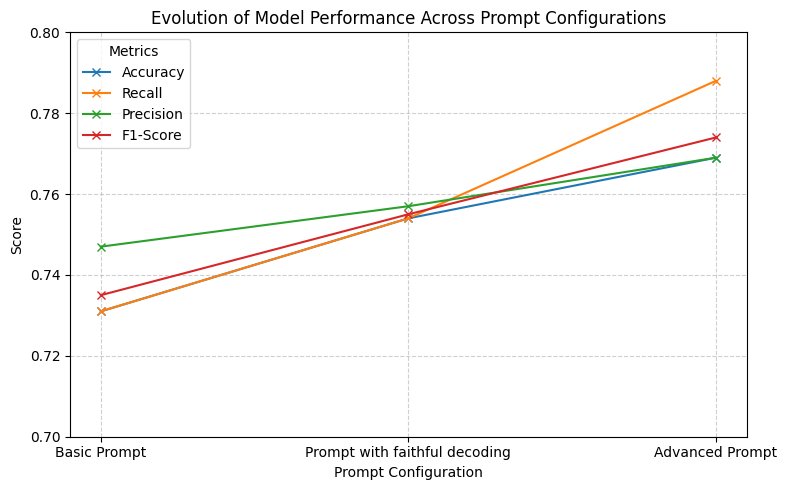

In [29]:
# summary results
summary_results = [
    {'Config': 'Basic Prompt', 'LLM': 'Llama 3.1 8B - Instruct', 'Embedding Model': 'Qwen 0.6B',
     'Accuracy': 0.731, 'Recall': 0.731, 'Precision': 0.747, 'F1-Score': 0.735, 'Resources': '1.92 min/report'},
    {'Config': 'Prompt with faithful decoding', 'LLM': 'Llama 3.1 8B - Instruct', 'Embedding Model': 'Qwen 0.6B',
     'Accuracy': 0.754, 'Recall': 0.754, 'Precision': 0.757, 'F1-Score': 0.755, 'Resources': '1.59 min/report'},
    {'Config': 'Advanced Prompt', 'LLM': 'Llama 3.1 8B - Instruct', 'Embedding Model': 'Qwen 0.6B',
     'Accuracy': 0.769, 'Recall': 0.788, 'Precision': 0.769, 'F1-Score': 0.774, 'Resources': '1.85 min/report'}
]

# Convert to DataFrame
df = pd.DataFrame(summary_results)

# Set the configuration as the index for plotting order
df.set_index("Config", inplace=True)

# Select metrics to plot
metrics = ['Accuracy', 'Recall', 'Precision', 'F1-Score']

# Plot
plt.figure(figsize=(8, 5))
for metric in metrics:
    plt.plot(df.index, df[metric], marker='x', label=metric)

plt.title('Evolution of Model Performance Across Prompt Configurations')
plt.xlabel('Prompt Configuration')
plt.ylabel('Score')
plt.ylim(0.70, 0.80)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Metrics')
plt.tight_layout()
plt.show()


# PDF Extraction
## 1. PyMuPDF4LLM
https://pymupdf.readthedocs.io/en/latest/pymupdf4llm/index.html

In [17]:
### Adjusted for PyMuPDF4LLM ###

## 1. Parse the Document ##
def parse_pdf_4llm(path=None, url=None):
    assert (path is not None) != (url is not None), "Provide either a local path or a URL."

    if path:
        doc_pages = pymupdf4llm.to_markdown(path, page_chunks=True)
    else:
        response = requests.get(url)
        doc_pages = pymupdf4llm.to_markdown(io.BytesIO(response.content), page_chunks=True)

    pages = [page_dict["text"] for page_dict in doc_pages]
    metadata = [{"page": str(page_dict["metadata"]["page"])} for page_dict in doc_pages]

    full_text = "".join(pages)
    return pages, full_text, metadata


## 2. Chunk the text ##
def chunk_text_4llm(pages, metadata, chunk_size=CHUNK_SIZE, chunk_overlap=CHUNK_OVERLAP):
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=len,
        separators=["\n\n", "\n", " "],
    )

    chunks = []
    chunk_metadata = []

    for idx, page in enumerate(pages):
        page_chunks = splitter.split_text(page)
        chunks.extend(page_chunks)
        chunk_metadata.extend([metadata[idx]] * len(page_chunks))

    return chunks, chunk_metadata


In [18]:
start_time = time.time()

# Your pipeline execution 
retrieved_chunks = {}  # Holds retrieved text chunks per report
report_ids = []        # Stores report IDs for final LLM analysis

# Loop through each report in your sample DataFrame
for idx, row in sample.iterrows():
    company_name = row['company_withAccessInfo']
    report_id = f"{prepare_filename(company_name)}_2024".replace(" ", "")
    print(f"\n Processing: {report_id}")

    # 1. Parse the document
    path = f"./sample_reports/{report_id}.pdf"
    pages, _, metadata = parse_pdf_4llm(path=path)

    # 2. Chunk the text
    chunks, metadata = chunk_text_4llm(pages, metadata, chunk_size=CHUNK_SIZE, chunk_overlap=CHUNK_OVERLAP)

    # 3. Generate and store vector representations
    db_path = f"./faiss_db_PdfExtraction1/{report_id}"
    vectorstore = get_vectorstore(chunks, metadata, db_path, embedding_model=embeddings_qwen)

    # 4. Retrieve the relevant chunks
    result = retrieve_chunks(vectorstore, queries=QUERIES, report_id=report_id, top_k=TOP_K)
    retrieved_chunks.update(result)
    report_ids.append(report_id)

# 5. Generate LLM answers
    # 1. Prepare prompts
prompts, metadata, final_analysis = prepare_prompts(
    report_list=report_ids,
    section_text_dict=retrieved_chunks
)
    # 2. Run inference
model_responses = run_batched_inference(prompts, generate_text)
    # 3. Parse and finalize results
final_analysis = parse_results(
    model_responses,
    metadata,
    final_analysis
)

time_per_report = (time.time() - start_time) / len(report_ids) / 60  # in minutes
print("Processing time per report in minutes", time_per_report)

evaluate_verdicts(
    validation_set,
    final_analysis,
    config_name="PDF Extraction: MyPuPDF4LLM",
    llm_name="Llama 3.1 8B - Instruct",
    embedding_model="Qwen 0.6B",
    resources=f"{time_per_report:.2f} min/report"
)


 Processing: SchneiderElectric_2024

 Processing: ContinentalAG_2024
--- Step 1: Preparing all prompts ---

--- Step 2: Sending 130 prompts to the pipeline ---
Generated LLM answers — Computation time: 2.65 minutes

--- Step 3: Parsing all responses ---
Processing time per report in minutes 5.313419810930887

--- LLM Evaluation: Evaluating performance on verdicts ---

 Dropped 0 of 130 queries due to missing verdicts.


{'accuracy': 0.654, 'precision': 0.744, 'recall': 0.654, 'f1_score': 0.661}

In [19]:
# read in old summary
old_comparison = pd.read_excel('rag_comparison.xlsx')

df_new = pd.DataFrame(summary_results)  # Your newly calculated metrics
df_summary = pd.concat([old_comparison, df_new], ignore_index=True)

# Save back to the same file
df_summary.to_excel("rag_comparison.xlsx", index=False)
print(df_summary)

                        Config                        LLM  \
0                   Baseline 1  OpenAI: gpt-4o-2024-08-06   
1                   Baseline 2    Llama 3.1 8B - Instruct   
2                   Baseline 3    Llama 3.1 8B - Instruct   
3                   Baseline 4   Llama 3.3 70B - Instruct   
4                   Baseline 5   Llama 3.3 70B - Instruct   
5  PDF Extraction: MyPuPDF4LLM    Llama 3.1 8B - Instruct   

                  Embedding Model  Accuracy  Recall  Precision  F1-Score  \
0  OpenAI: text-embedding-ada-002     0.808   0.808      0.811     0.796   
1                       Qwen 0.6B     0.769   0.769      0.788     0.774   
2                         Qwen 4B     0.700   0.700      0.733     0.708   
3                       Qwen 0.6B     0.738   0.738      0.731     0.733   
4                         Qwen 4B     0.715   0.715      0.706     0.709   
5                       Qwen 0.6B     0.654   0.654      0.744     0.661   

          Resources  
0   6.96 min/repo

# Retrieval Settings
## 1. based on Gehricke et al. (2025):
- Chunk size 400
- chunk overlap 50
- top K 10

In [20]:
TOP_K = 10
CHUNK_SIZE = 400
CHUNK_OVERLAP = 50

start_time = time.time()

# Your pipeline execution 
retrieved_chunks = {}  # Holds retrieved text chunks per report
report_ids = []        # Stores report IDs for final LLM analysis

# Loop through each report in your sample DataFrame
for idx, row in sample.iterrows():
    company_name = row['company_withAccessInfo']
    report_id = f"{prepare_filename(company_name)}_2024".replace(" ", "")
    print(f"\n Processing: {report_id}")

    # 1. Parse the document
    path = f"./sample_reports/{report_id}.pdf"
    pages, _ = parse_pdf(path=path)

    # 2. Chunk the text
    chunks, metadata = chunk_text(pages, chunk_size=CHUNK_SIZE, chunk_overlap=CHUNK_OVERLAP)

    # 3. Generate and store vector representations
    db_path = f"./faiss_db_RetrievalSettings1/{report_id}"
    vectorstore = get_vectorstore(chunks, metadata, db_path, embedding_model=embeddings_qwen)

    # 4. Retrieve the relevant chunks
    result = retrieve_chunks(vectorstore, queries=QUERIES, report_id=report_id, top_k=TOP_K)
    retrieved_chunks.update(result)
    report_ids.append(report_id)

# 5. Generate LLM answers
    # 1. Prepare prompts
prompts, metadata, final_analysis = prepare_prompts(
    report_list=report_ids,
    section_text_dict=retrieved_chunks
)
    # 2. Run inference
model_responses = run_batched_inference(prompts, generate_text)
    # 3. Parse and finalize results
final_analysis = parse_results(
    model_responses,
    metadata,
    final_analysis
)

time_per_report = (time.time() - start_time) / len(report_ids) / 60  # in minutes
print("Processing time per report in minutes", time_per_report)

evaluate_verdicts(
    validation_set,
    final_analysis,
    config_name="Retrieval Settings 1",
    llm_name="Llama 3.1 8B - Instruct",
    embedding_model="Qwen 0.6B",
    resources=f"{time_per_report:.2f} min/report"
)


 Processing: SchneiderElectric_2024

 Processing: ContinentalAG_2024
--- Step 1: Preparing all prompts ---

--- Step 2: Sending 130 prompts to the pipeline ---
Generated LLM answers — Computation time: 4.32 minutes

--- Step 3: Parsing all responses ---
Processing time per report in minutes 3.4678354501724242

--- LLM Evaluation: Evaluating performance on verdicts ---

 Dropped 0 of 130 queries due to missing verdicts.


{'accuracy': 0.754, 'precision': 0.764, 'recall': 0.754, 'f1_score': 0.757}

In [21]:
# read in old summary
old_comparison = pd.read_excel('rag_comparison.xlsx')

df_new = pd.DataFrame(summary_results)  # Your newly calculated metrics
summary_results = []
df_new["TOP_K"] = TOP_K
df_new["CHUNK_SIZE"] = CHUNK_SIZE
df_new["CHUNK_OVERLAP"] = CHUNK_OVERLAP
df_summary = pd.concat([old_comparison, df_new], ignore_index=True)

# Save back to the same file
df_summary.to_excel("rag_comparison.xlsx", index=False)
print(df_summary)

                        Config                        LLM  \
0                   Baseline 1  OpenAI: gpt-4o-2024-08-06   
1                   Baseline 2    Llama 3.1 8B - Instruct   
2                   Baseline 3    Llama 3.1 8B - Instruct   
3                   Baseline 4   Llama 3.3 70B - Instruct   
4                   Baseline 5   Llama 3.3 70B - Instruct   
5  PDF Extraction: MyPuPDF4LLM    Llama 3.1 8B - Instruct   
6  PDF Extraction: MyPuPDF4LLM    Llama 3.1 8B - Instruct   
7         Retrieval Settings 1    Llama 3.1 8B - Instruct   

                  Embedding Model  Accuracy  Recall  Precision  F1-Score  \
0  OpenAI: text-embedding-ada-002     0.808   0.808      0.811     0.796   
1                       Qwen 0.6B     0.769   0.769      0.788     0.774   
2                         Qwen 4B     0.700   0.700      0.733     0.708   
3                       Qwen 0.6B     0.738   0.738      0.731     0.733   
4                         Qwen 4B     0.715   0.715      0.706     0.7

## 2. based on Forster et al. (2025):
- Chunk size 400
- chunk overlap 100
- top K 10

In [22]:
TOP_K = 10
CHUNK_SIZE = 400
CHUNK_OVERLAP = 100

start_time = time.time()

# Your pipeline execution 
retrieved_chunks = {}  # Holds retrieved text chunks per report
report_ids = []        # Stores report IDs for final LLM analysis

# Loop through each report in your sample DataFrame
for idx, row in sample.iterrows():
    company_name = row['company_withAccessInfo']
    report_id = f"{prepare_filename(company_name)}_2024".replace(" ", "")
    print(f"\n Processing: {report_id}")

    # 1. Parse the document
    path = f"./sample_reports/{report_id}.pdf"
    pages, _ = parse_pdf(path=path)

    # 2. Chunk the text
    chunks, metadata = chunk_text(pages, chunk_size=CHUNK_SIZE, chunk_overlap=CHUNK_OVERLAP)

    # 3. Generate and store vector representations
    db_path = f"./faiss_db_RetrievalSettings2/{report_id}"
    vectorstore = get_vectorstore(chunks, metadata, db_path, embedding_model=embeddings_qwen)

    # 4. Retrieve the relevant chunks
    result = retrieve_chunks(vectorstore, queries=QUERIES, report_id=report_id, top_k=TOP_K)
    retrieved_chunks.update(result)
    report_ids.append(report_id)

# 5. Generate LLM answers
    # 1. Prepare prompts
prompts, metadata, final_analysis = prepare_prompts(
    report_list=report_ids,
    section_text_dict=retrieved_chunks
)
    # 2. Run inference
model_responses = run_batched_inference(prompts, generate_text)
    # 3. Parse and finalize results
final_analysis = parse_results(
    model_responses,
    metadata,
    final_analysis
)

time_per_report = (time.time() - start_time) / len(report_ids) / 60  # in minutes
print("Processing time per report in minutes", time_per_report)

evaluate_verdicts(
    validation_set,
    final_analysis,
    config_name="Retrieval Settings 2",
    llm_name="Llama 3.1 8B - Instruct",
    embedding_model="Qwen 0.6B",
    resources=f"{time_per_report:.2f} min/report"
)


 Processing: SchneiderElectric_2024

 Processing: ContinentalAG_2024
--- Step 1: Preparing all prompts ---

--- Step 2: Sending 130 prompts to the pipeline ---
Generated LLM answers — Computation time: 3.89 minutes

--- Step 3: Parsing all responses ---
Processing time per report in minutes 3.4469019850095113

--- LLM Evaluation: Evaluating performance on verdicts ---

 Dropped 0 of 130 queries due to missing verdicts.


{'accuracy': 0.731, 'precision': 0.739, 'recall': 0.731, 'f1_score': 0.734}

In [23]:
# read in old summary
old_comparison = pd.read_excel('rag_comparison.xlsx')

df_new = pd.DataFrame(summary_results)  # Your newly calculated metrics
summary_results = []
df_new["TOP_K"] = TOP_K
df_new["CHUNK_SIZE"] = CHUNK_SIZE
df_new["CHUNK_OVERLAP"] = CHUNK_OVERLAP
df_summary = pd.concat([old_comparison, df_new], ignore_index=True)

# Save back to the same file
df_summary.to_excel("rag_comparison.xlsx", index=False)
print(df_summary)

                        Config                        LLM  \
0                   Baseline 1  OpenAI: gpt-4o-2024-08-06   
1                   Baseline 2    Llama 3.1 8B - Instruct   
2                   Baseline 3    Llama 3.1 8B - Instruct   
3                   Baseline 4   Llama 3.3 70B - Instruct   
4                   Baseline 5   Llama 3.3 70B - Instruct   
5  PDF Extraction: MyPuPDF4LLM    Llama 3.1 8B - Instruct   
6  PDF Extraction: MyPuPDF4LLM    Llama 3.1 8B - Instruct   
7         Retrieval Settings 1    Llama 3.1 8B - Instruct   
8         Retrieval Settings 2    Llama 3.1 8B - Instruct   

                  Embedding Model  Accuracy  Recall  Precision  F1-Score  \
0  OpenAI: text-embedding-ada-002     0.808   0.808      0.811     0.796   
1                       Qwen 0.6B     0.769   0.769      0.788     0.774   
2                         Qwen 4B     0.700   0.700      0.733     0.708   
3                       Qwen 0.6B     0.738   0.738      0.731     0.733   
4        

## 3. based on Ni et al. (2023):
- Chunk size 500
- chunk overlap 20
- top K 20

In [14]:
TOP_K = 20
CHUNK_SIZE = 500
CHUNK_OVERLAP = 20

start_time = time.time()

# Your pipeline execution 
retrieved_chunks = {}  # Holds retrieved text chunks per report
report_ids = []        # Stores report IDs for final LLM analysis

# Loop through each report in your sample DataFrame
for idx, row in sample.iterrows():
    company_name = row['company_withAccessInfo']
    report_id = f"{prepare_filename(company_name)}_2024".replace(" ", "")
    print(f"\n Processing: {report_id}")

    # 1. Parse the document
    path = f"./sample_reports/{report_id}.pdf"
    pages, _ = parse_pdf(path=path)

    # 2. Chunk the text
    chunks, metadata = chunk_text(pages, chunk_size=CHUNK_SIZE, chunk_overlap=CHUNK_OVERLAP)

    # 3. Generate and store vector representations
    db_path = f"./faiss_db_RetrievalSettings3/{report_id}"
    vectorstore = get_vectorstore(chunks, metadata, db_path, embedding_model=embeddings_qwen)

    # 4. Retrieve the relevant chunks
    result = retrieve_chunks(vectorstore, queries=QUERIES, report_id=report_id, top_k=TOP_K)
    retrieved_chunks.update(result)
    report_ids.append(report_id)

# 5. Generate LLM answers
    # 1. Prepare prompts
prompts, metadata, final_analysis = prepare_prompts(
    report_list=report_ids,
    section_text_dict=retrieved_chunks
)
    # 2. Run inference
model_responses = run_batched_inference(prompts, generate_text)
    # 3. Parse and finalize results
final_analysis = parse_results(
    model_responses,
    metadata,
    final_analysis
)

time_per_report = (time.time() - start_time) / len(report_ids) / 60  # in minutes
print("Processing time per report in minutes", time_per_report)

evaluate_verdicts(
    validation_set,
    final_analysis,
    config_name="Retrieval Settings 3",
    llm_name="Llama 3.1 8B - Instruct",
    embedding_model="Qwen 0.6B",
    resources=f"{time_per_report:.2f} min/report"
)


 Processing: SchneiderElectric_2024

 Processing: ContinentalAG_2024
--- Step 1: Preparing all prompts ---

--- Step 2: Sending 130 prompts to the pipeline ---
Generated LLM answers — Computation time: 6.42 minutes

--- Step 3: Parsing all responses ---
Processing time per report in minutes 3.270663567384084

--- LLM Evaluation: Evaluating performance on verdicts ---

 Dropped 0 of 130 queries due to missing verdicts.


{'accuracy': 0.738, 'precision': 0.729, 'recall': 0.738, 'f1_score': 0.729}

In [15]:
# read in old summary
old_comparison = pd.read_excel('rag_comparison.xlsx')

df_new = pd.DataFrame(summary_results)  # Your newly calculated metrics
summary_results = []
df_new["TOP_K"] = TOP_K
df_new["CHUNK_SIZE"] = CHUNK_SIZE
df_new["CHUNK_OVERLAP"] = CHUNK_OVERLAP
df_summary = pd.concat([old_comparison, df_new], ignore_index=True)

# Save back to the same file
df_summary.to_excel("rag_comparison.xlsx", index=False)
print(df_summary)

                        Config                        LLM  \
0                   Baseline 1  OpenAI: gpt-4o-2024-08-06   
1                   Baseline 2    Llama 3.1 8B - Instruct   
2                   Baseline 3    Llama 3.1 8B - Instruct   
3                   Baseline 4   Llama 3.3 70B - Instruct   
4                   Baseline 5   Llama 3.3 70B - Instruct   
5  PDF Extraction: MyPuPDF4LLM    Llama 3.1 8B - Instruct   
6  PDF Extraction: MyPuPDF4LLM    Llama 3.1 8B - Instruct   
7         Retrieval Settings 1    Llama 3.1 8B - Instruct   
8         Retrieval Settings 2    Llama 3.1 8B - Instruct   
9         Retrieval Settings 3    Llama 3.1 8B - Instruct   

                  Embedding Model  Accuracy  Recall  Precision  F1-Score  \
0  OpenAI: text-embedding-ada-002     0.808   0.808      0.811     0.796   
1                       Qwen 0.6B     0.769   0.769      0.788     0.774   
2                         Qwen 4B     0.700   0.700      0.733     0.708   
3                       

## 4.
- Chunk size 400
- chunk overlap 100
- top K 12

In [17]:
TOP_K = 12
CHUNK_SIZE = 400
CHUNK_OVERLAP = 100

start_time = time.time()

# Your pipeline execution 
retrieved_chunks = {}  # Holds retrieved text chunks per report
report_ids = []        # Stores report IDs for final LLM analysis

# Loop through each report in your sample DataFrame
for idx, row in sample.iterrows():
    company_name = row['company_withAccessInfo']
    report_id = f"{prepare_filename(company_name)}_2024".replace(" ", "")
    print(f"\n Processing: {report_id}")

    # 1. Parse the document
    path = f"./sample_reports/{report_id}.pdf"
    pages, _ = parse_pdf(path=path)

    # 2. Chunk the text
    chunks, metadata = chunk_text(pages, chunk_size=CHUNK_SIZE, chunk_overlap=CHUNK_OVERLAP)

    # 3. Generate and store vector representations
    db_path = f"./faiss_db_RetrievalSettings4/{report_id}"
    vectorstore = get_vectorstore(chunks, metadata, db_path, embedding_model=embeddings_qwen)

    # 4. Retrieve the relevant chunks
    result = retrieve_chunks(vectorstore, queries=QUERIES, report_id=report_id, top_k=TOP_K)
    retrieved_chunks.update(result)
    report_ids.append(report_id)

# 5. Generate LLM answers
    # 1. Prepare prompts
prompts, metadata, final_analysis = prepare_prompts(
    report_list=report_ids,
    section_text_dict=retrieved_chunks
)
    # 2. Run inference
model_responses = run_batched_inference(prompts, generate_text)
    # 3. Parse and finalize results
final_analysis = parse_results(
    model_responses,
    metadata,
    final_analysis
)

time_per_report = (time.time() - start_time) / len(report_ids) / 60  # in minutes
print("Processing time per report in minutes", time_per_report)

evaluate_verdicts(
    validation_set,
    final_analysis,
    config_name="Retrieval Settings 4",
    llm_name="Llama 3.1 8B - Instruct",
    embedding_model="Qwen 0.6B",
    resources=f"{time_per_report:.2f} min/report"
)


 Processing: SchneiderElectric_2024

 Processing: ContinentalAG_2024
--- Step 1: Preparing all prompts ---

--- Step 2: Sending 130 prompts to the pipeline ---
Generated LLM answers — Computation time: 4.09 minutes

--- Step 3: Parsing all responses ---
Processing time per report in minutes 3.5524419963359835

--- LLM Evaluation: Evaluating performance on verdicts ---

 Dropped 0 of 130 queries due to missing verdicts.


{'accuracy': 0.754, 'precision': 0.754, 'recall': 0.754, 'f1_score': 0.754}

In [18]:
# read in old summary
old_comparison = pd.read_excel('rag_comparison.xlsx')

df_new = pd.DataFrame(summary_results)  # Your newly calculated metrics
summary_results = []
df_new["TOP_K"] = TOP_K
df_new["CHUNK_SIZE"] = CHUNK_SIZE
df_new["CHUNK_OVERLAP"] = CHUNK_OVERLAP
df_summary = pd.concat([old_comparison, df_new], ignore_index=True)

# Save back to the same file
df_summary.to_excel("rag_comparison.xlsx", index=False)
print(df_summary)

                         Config                        LLM  \
0                    Baseline 1  OpenAI: gpt-4o-2024-08-06   
1                    Baseline 2    Llama 3.1 8B - Instruct   
2                    Baseline 3    Llama 3.1 8B - Instruct   
3                    Baseline 4   Llama 3.3 70B - Instruct   
4                    Baseline 5   Llama 3.3 70B - Instruct   
5   PDF Extraction: MyPuPDF4LLM    Llama 3.1 8B - Instruct   
6   PDF Extraction: MyPuPDF4LLM    Llama 3.1 8B - Instruct   
7          Retrieval Settings 1    Llama 3.1 8B - Instruct   
8          Retrieval Settings 2    Llama 3.1 8B - Instruct   
9          Retrieval Settings 3    Llama 3.1 8B - Instruct   
10         Retrieval Settings 4    Llama 3.1 8B - Instruct   

                   Embedding Model  Accuracy  Recall  Precision  F1-Score  \
0   OpenAI: text-embedding-ada-002     0.808   0.808      0.811     0.796   
1                        Qwen 0.6B     0.769   0.769      0.788     0.774   
2                       

In [19]:
TOP_K = 8
CHUNK_SIZE = 350
CHUNK_OVERLAP = 50

start_time = time.time()

# Your pipeline execution 
retrieved_chunks = {}  # Holds retrieved text chunks per report
report_ids = []        # Stores report IDs for final LLM analysis

# Loop through each report in your sample DataFrame
for idx, row in sample.iterrows():
    company_name = row['company_withAccessInfo']
    report_id = f"{prepare_filename(company_name)}_2024".replace(" ", "")
    print(f"\n Processing: {report_id}")

    # 1. Parse the document
    path = f"./sample_reports/{report_id}.pdf"
    pages, _ = parse_pdf(path=path)

    # 2. Chunk the text
    chunks, metadata = chunk_text(pages, chunk_size=CHUNK_SIZE, chunk_overlap=CHUNK_OVERLAP)

    # 3. Generate and store vector representations
    db_path = f"./faiss_db_again/{report_id}"
    vectorstore = get_vectorstore(chunks, metadata, db_path, embedding_model=embeddings_qwen)

    # 4. Retrieve the relevant chunks
    result = retrieve_chunks(vectorstore, queries=QUERIES, report_id=report_id, top_k=TOP_K)
    retrieved_chunks.update(result)
    report_ids.append(report_id)

# 5. Generate LLM answers
    # 1. Prepare prompts
prompts, metadata, final_analysis = prepare_prompts(
    report_list=report_ids,
    section_text_dict=retrieved_chunks
)
    # 2. Run inference
model_responses = run_batched_inference(prompts, generate_text)
    # 3. Parse and finalize results
final_analysis = parse_results(
    model_responses,
    metadata,
    final_analysis
)

time_per_report = (time.time() - start_time) / len(report_ids) / 60  # in minutes
print("Processing time per report in minutes", time_per_report)

evaluate_verdicts(
    validation_set,
    final_analysis,
    config_name="Retrieval Settings 4",
    llm_name="Llama 3.1 8B - Instruct",
    embedding_model="Qwen 0.6B",
    resources=f"{time_per_report:.2f} min/report"
)


 Processing: SchneiderElectric_2024

 Processing: ContinentalAG_2024
--- Step 1: Preparing all prompts ---

--- Step 2: Sending 130 prompts to the pipeline ---
Generated LLM answers — Computation time: 3.61 minutes

--- Step 3: Parsing all responses ---
Processing time per report in minutes 3.1158853590488436

--- LLM Evaluation: Evaluating performance on verdicts ---

 Dropped 0 of 130 queries due to missing verdicts.


{'accuracy': 0.777, 'precision': 0.793, 'recall': 0.777, 'f1_score': 0.781}